In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping



In [5]:

# Load & normalize MNIST
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Reshape to (N,28,28,1) for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [6]:
# Define a noise‐injection function
def add_gaussian_noise(imgs, std=0.1):
    noise = np.random.normal(0.0, std, imgs.shape)
    return np.clip(imgs + noise, 0.0, 1.0)

# Split each set in half
n_train   = x_train.shape[0]
half_train = n_train // 2

n_test    = x_test.shape[0]
half_test  = n_test // 2

# Apply noise only to the second half
x_train_noisy = add_gaussian_noise(x_train[half_train:], std=0.1)
x_test_noisy  = add_gaussian_noise(x_test[half_test:],     std=0.1)

# Re‐assemble full datasets
x_train_aug = np.concatenate([x_train[:half_train], x_train_noisy], axis=0)
y_train_aug = np.concatenate([y_train[:half_train], y_train[half_train:]], axis=0)

x_test_aug  = np.concatenate([x_test[:half_test],  x_test_noisy], axis=0)
y_test_aug  = np.concatenate([y_test[:half_test],  y_test[half_test:]], axis=0)

# Shuffle the training data so that clean/noisy are mixed
perm = np.random.permutation(n_train)
x_train_aug = x_train_aug[perm]
y_train_aug = y_train_aug[perm]


In [7]:
# Set up image augmentation
aug = ImageDataGenerator(
    rotation_range=10,        # ±10° rotation
    width_shift_range=0.1,    # ±10% horizontal shift
    height_shift_range=0.1,   # ±10% vertical shift
    zoom_range=0.1            # ±10% zoom
)


In [8]:
# Build the CNN
num_classes = 10
model = models.Sequential([
    layers.Input(shape=(28,28,1)),

    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Flatten(),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])


In [9]:
model.summary()   # prints layer-by-layer output shapes and param counts


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,722 (1.75 MB)

 Trainable params: 459,146 (1.75 MB)

 Non-trainable params: 576 (2.25 KB)

In [10]:
# Compile with Adam & sparse CCE
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [11]:
# Early stopping on validation loss
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


In [12]:
# Train using the augmented generator
batch_size = 32
history= model.fit(
    aug.flow(x_train_aug, y_train_aug, batch_size=batch_size),
    steps_per_epoch=len(x_train_aug)//batch_size,
    epochs=10,
    validation_data=(x_test_aug, y_test_aug),
    callbacks=[early_stopping]

    )


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - accuracy: 0.8085 - loss: 0.6104 - val_accuracy: 0.9788 - val_loss: 0.0609
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.9555 - loss: 0.1497 - val_accuracy: 0.9896 - val_loss: 0.0309
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9651 - loss: 0.1143 - val_accuracy: 0.9842 - val_loss: 0.0513
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9692 - loss: 0.0988 - val_accuracy: 0.9911 - val_loss: 0.0260
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - accuracy: 0.9730 - loss: 0.0929 - val_accuracy: 0.9914 - val_loss: 0.0240
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.9756 - loss: 0.0807 - val_accuracy: 0.9929 - val_loss: 0.0224
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9775 - loss: 0.0760 - val_accuracy: 0.9932 - val_loss: 0.0203
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9790 - loss: 0.07

In [13]:
# Print final accuracies of training and validation data set
train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]
print(f"Final Training   Accuracy: {train_acc  * 100:.2f}%")
print(f"Final Validation Accuracy: {val_acc    * 100:.2f}%")

# Final evaluation
test_loss, test_acc = model.evaluate(x_test_aug, y_test_aug, verbose=0)
print(f"Test accuracy: {test_acc * 100:.2f}%")


Final Training   Accuracy: 98.16%
Final Validation Accuracy: 99.37%
Test accuracy: 99.37%


In [14]:
import cv2
from google.colab import files
uploaded = files.upload()

import matplotlib.pyplot as plt


Saving phone_number_1.png to phone_number_1.png


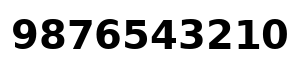

In [15]:
from google.colab.patches import cv2_imshow

filename = list(uploaded.keys())[0]  # Automatically gets uploaded file name
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

if img is None:
    print("Could not read the image.")
else:
    cv2_imshow(img)


In [16]:
# Apply threshold to binarize
_, thresh = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from left to right
bounding_boxes = [cv2.boundingRect(c) for c in contours]
bounding_boxes.sort(key=lambda x: x[0])


In [17]:
digit_images = []

for x, y, w, h in bounding_boxes:
    digit = thresh[y:y+h, x:x+w]           # Crop digit
    digit = cv2.resize(digit, (28, 28))    # Resize to fit model
    digit = digit.astype('float32') / 255.0
    digit = np.expand_dims(digit, axis=-1) # Add channel dimension
    digit_images.append(digit)

# Convert to NumPy array for batch prediction
digit_images = np.array(digit_images)


In [18]:
predictions = model.predict(digit_images)
predicted_digits = np.argmax(predictions, axis=1)
phone_number = ''.join(str(d) for d in predicted_digits)

print("Detected Phone Number:", phone_number)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
Detected Phone Number: 9876593220
